#### ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)
***N. Hernitschek***
___

# Homework 12
### Due: Monday, Apr 25th at 11.00am CST

The completed lecture notebook must also be submitted by 11:00am Central Time on Apr 25th.

**This is your last homework assignment.**

---

## Problem 1

**Density Estimation and Clustering**

Fill in the blanks below and answer all questions. This exercise will take you though some topics from this and last week.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import homogeneity_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KernelDensity
from astroML.density_estimation import KNeighborsDensity
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

Setup up the data set. We will do both density estimation and clustering on it.

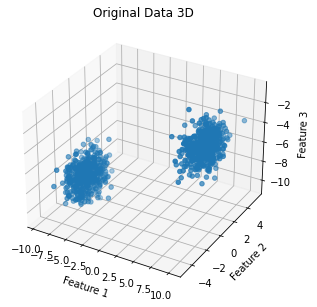

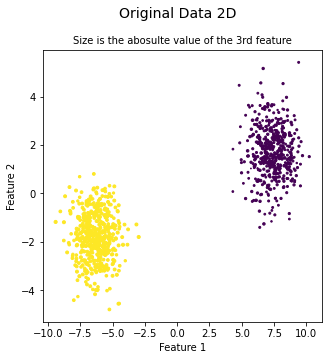

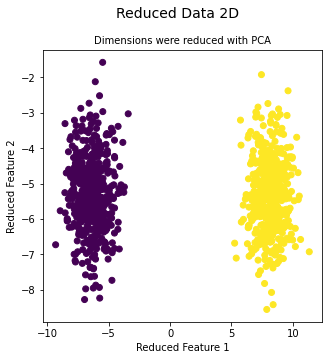

In [2]:
#Make two blobs with 3 features and 1000 samples
N = 1000
X,y = make_blobs(n_samples=N, centers=2, n_features=3, random_state=25)

#The remainder of the homework is set up to take data with 2 features
#Therefore, PCA was used to reduce the data from the two blobs with 3 features to data with 2 features 
n_components = 3
pca = PCA(n_components - 1, svd_solver='randomized')
pca.fit(X)
X_reduced = np.matmul(X,np.transpose(pca.components_))

#Plot 3 dimensions in 3d
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('Original Data 3D')

#Plot 3 dimensions in 2d
plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], s=abs(X[:, 2]), c=y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title('Size is the abosulte value of the 3rd feature',fontsize=10)
plt.suptitle('Original Data 2D',fontsize=14, y=1)

#Plot 2 dimensions in 2d
plt.figure(figsize=(5,5))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y)
plt.xlabel("Reduced Feature 1")
plt.ylabel("Reduced Feature 2")
plt.title('Dimensions were reduced with PCA',fontsize=10)
plt.suptitle('Reduced Data 2D',fontsize=14, y=1)

#Set X_reduced to X for remainder of problems
X=X_reduced

Start with kernel density estimation, including a grid search to find the best bandwidth.

C:\Users\jtsen\AppData\Local\Temp\ipykernel_34352\3939476794.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T


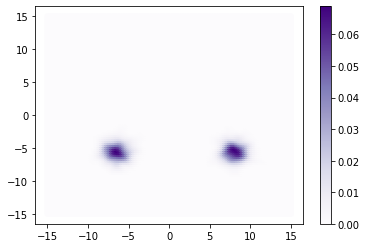

In [3]:
bwrange = np.linspace(.1,1,30)                          #Test 30 bandwidths from 0.1 to 1.0
K = 5                                                   #5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) 
grid.fit(X)                                             #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']

kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(X)                                              #Fit the model to the data

u = v = np.linspace(-15,15,100)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T
dens = np.exp(kde.score_samples(Xgrid))                 #Evaluate the model on the grid

plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens, cmap="Purples", edgecolor="None") 
plt.colorbar()


Now try a nearest neighbors approach to estimating the density.
What value of do you need to make the plot look similar to the one above?


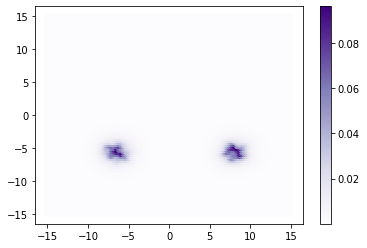

In [4]:
#Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian',n_neighbors=30)
nbrs.fit(X)
dens_nbrs = nbrs.eval(Xgrid) / N

plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens_nbrs, cmap="Purples", edgecolor="None")
plt.colorbar()

Now do a Gaussian mixture model. Do a grid search for between 1 and 10 components.


2


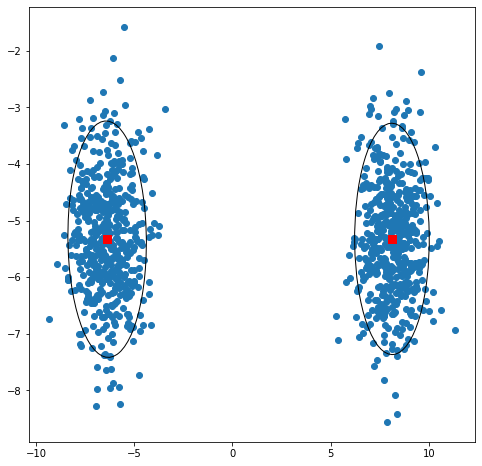

In [5]:
#Kludge to fix the bug with draw_ellipse in astroML v1.0
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    #Find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,(sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

                             
ncomps = np.arange(1,10,1)                                             #Test 10 bandwidths from 1 to 10
K = 5                                                                  #5-fold cross validation
grid = GridSearchCV(GaussianMixture(), {'n_components': ncomps}, cv=K)
grid.fit(X)                                                            #Fit the histogram data that we started the lecture with.
ncomp_opt = grid.best_params_['n_components']
print(ncomp_opt)

gmm = GaussianMixture(n_components=ncomp_opt)
gmm.fit(X)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(X[:,0],X[:,1])

ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='s', c='red', s=80)
for mu, C, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(mu, 1*C, scales=[2], ax=ax, fc='none', ec='k')         #2 sigma ellipses for each component

Do you get the same answer (the same number of components) each time you run it?
Why is that the case?

No, I get 2-3 clusters (usually 2). This is because gaussian mixture model is non-deterministic.

Now try Kmeans. Here we will scale the data.


Text(0.5, 1.0, 'Truth')

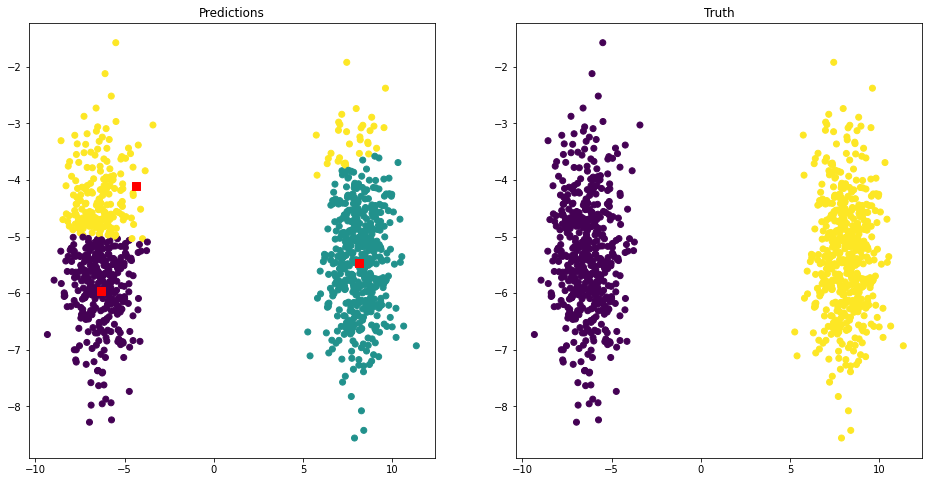

In [6]:
kmeans = KMeans(n_clusters=3)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans.fit(X_scaled)
centers=kmeans.cluster_centers_                      #location of the clusters
labels=kmeans.predict(X_scaled)                      #labels for each of the points
centers_unscaled = scaler.inverse_transform(centers)


fig,ax = plt.subplots(1,2,figsize=(16, 8))
ax[0].scatter(X[:,0],X[:,1],c=labels)
ax[0].scatter(centers_unscaled[:,0], centers_unscaled[:,1], marker='s', c='red', s=80)
ax[0].set_title("Predictions")

ax[1].scatter(X[:, 0], X[:, 1], c=y)
ax[1].set_title("Truth")


Let's evaluate how well we did in two other ways: a matrix and a score.


In [7]:
df = pd.DataFrame({'predictions': labels, 'truth': y})
ct = pd.crosstab(df['predictions'], df['truth'])
print(ct)

from sklearn.metrics.cluster import homogeneity_score
score = homogeneity_score(df['truth'], df['predictions'])

truth          0    1
predictions          
0            315    0
1              0  468
2            185   32






What is the score for 3 clusters?


In [8]:
print("The score is ",round(score,4))
print("*The score is high because PCA effectively performed some of the seperation\nmaking it easier for clusters to achieve homogeneity")

The score is  0.869
*The score is high because PCA effectively performed some of the seperation
making it easier for clusters to achieve homogeneity
